In [2]:
import torch
from gamesopt.train import train, TrainConfig
from gamesopt.games import GameOptions, QuadraticGameConfig, GameType
from gamesopt.optimizer import OptimizerOptions, OptimizerType
from gamesopt.aggregator import AggregationOptions, AggregatorType
from gamesopt.attacks import AttackOptions, AttackType
import matplotlib.pyplot as plt
from gamesopt.games.utils import create_matrix

%matplotlib widget
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
n_iter = 200

n_peers = 20
n_byzan = 4

num_samples = 1000
dim = 100
with_bias = True
sigma = 1e-1  # actually scales sigma
mu = 1e-2
ell = 1e2

attack_type = AttackType.ALIE
n_attacking = n_byzan
ipm_epsilon = 1e1
rn_sigma = 1e6
alie_z = 1e2


use_bucketing = True
bucketing_s = 2
aggregator_type = AggregatorType.RFA
trimmed_mean_b = 10
krum_m = 2
clipping_tau = 102
clipping_n_iter = 1
rfa_T: int = 10
rfa_nu: int = 0.1

optimizer_type = OptimizerType.SGDARA
# optimizer_type = OptimizerType.MSGDARA
# optimizer_type = OptimizerType.SEGDARA
alpha = 0.1
lr = 1/2/ell
lr_inner = 1/2/(ell)
lr_outer = lr_inner/4
batch_size = 1
sigmaC = 100.

matrix, bias = create_matrix(dim, num_samples, mu, ell, sigma,
                             with_bias=with_bias)
true = torch.linalg.solve(matrix.mean(dim=0), -bias.mean(dim=0))
players = true + 1.

In [36]:
aggregation_options = AggregationOptions(n_peers=n_peers,
                                         n_byzan=n_byzan,
                                         aggregator_type=aggregator_type,
                                         use_bucketing=use_bucketing,
                                         bucketing_s=bucketing_s,
                                         trimmed_mean_b=trimmed_mean_b,
                                         krum_m=krum_m,
                                         clipping_tau=clipping_tau,
                                         clipping_n_iter=clipping_n_iter,
                                         rfa_T=rfa_T,
                                         rfa_nu=rfa_nu)

quadratic_game_options = QuadraticGameConfig(num_samples=num_samples,
                                             dim=dim,
                                             num_players=2,
                                             with_bias=with_bias,
                                             sigma=sigma,
                                             mu=mu,
                                             ell=ell,
                                             matrix=matrix,
                                             bias=bias,
                                             players=players,
                                             true=true)

game_options = GameOptions(GameType.QUADRATIC, quadratic_game_options)

attack_options = AttackOptions(n_peers=n_peers,
                               n_byzan=n_byzan,
                               n_attacking=n_attacking,
                               attack_type=attack_type,
                               ipm_epsilon=ipm_epsilon,
                               rn_sigma=rn_sigma,
                               alie_z=alie_z)

optimizer_options = OptimizerOptions(n_peers=n_peers,
                                     optimizer_type=optimizer_type,
                                     lr=lr,
                                     batch_size=batch_size,
                                     aggregation_options=aggregation_options,
                                     attack_options=attack_options,
                                     sigmaC=sigmaC,
                                     alpha=alpha,
                                     lr_inner=lr_inner,
                                     lr_outer=lr_outer)

config = TrainConfig(game=game_options,
                                optimizer=optimizer_options,
                                num_iter=n_iter,
                                n_peers=n_peers)
# print(config)

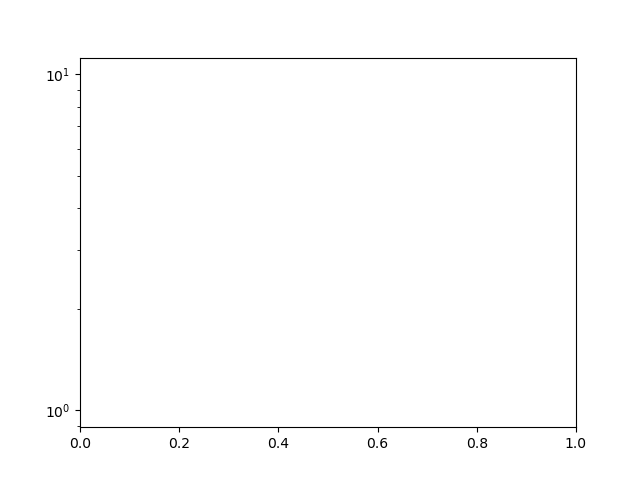

In [37]:
plt.figure()
plt.yscale('log')
config.optimizer.lr = 1/2/ell/15
config.num_iter = 5000

In [38]:
config.optimizer.optimizer_type = OptimizerType.SGDARA
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [39]:
config.optimizer.optimizer_type = OptimizerType.MSGDARA
config.optimizer.alpha = 0.1
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [40]:
config.optimizer.optimizer_type = OptimizerType.SEGRA
config.optimizer.lr_inner = config.optimizer.lr
config.optimizer.lr_outer = config.optimizer.lr
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [ ]:
config.optimizer.optimizer_type = OptimizerType.RDEG
config.optimizer.lr_inner = config.optimizer.lr
config.optimizer.lr_outer = config.optimizer.lr
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [ ]:
config.optimizer.optimizer_type = OptimizerType.SGDACC
config.optimizer.attack_options.n_attacking = 1
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [ ]:
config.optimizer.optimizer_type = OptimizerType.SEGCC
config.optimizer.attack_options.n_attacking = 1
record = train(config)
plt.plot(record.metrics.num_grad, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))

In [ ]:
plt.xscale('log')
plt.legend()
plt.show()

In [101]:
# plt.savefig('figures/true-start-m.pdf', bbox_inches='tight')